In [63]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import numpy as np
import pandas as pd
import modules
import matplotlib.pyplot as plt

from sklearn.metrics import *
from pathlib import Path

from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

np.random.seed(0)
torch.manual_seed(0)

In [64]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "results"

model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
unique_peptides = metadata["peptide"].unique()

In [65]:
validation_pep = "KTWGQYWQV"
unique_peptides = np.delete(unique_peptides, np.where(unique_peptides == validation_pep))

no_pos_peptides = ["CLGGLLTMV", "ILKEPVHGV"]
for pep in no_pos_peptides:
    unique_peptides = np.delete(unique_peptides, np.where(unique_peptides == pep))

threshold = 0.1
cv_fold = 5
excluded = [] # ["KLQCVDLHV", "KVAELVHFL", "YLLEMLWRL", "SLLMWITQV"]

In [66]:
overall_LOO_results_df = pd.DataFrame(columns=[
    "Model", 
    "AUC",
    f"MCC (threshold = {threshold})",
])

individual_AUC_results_df = pd.DataFrame(columns=["Model"] + list(unique_peptides))

individual_MCC_results_df = pd.DataFrame(columns=["Model"] + list(unique_peptides))

overall_CV_results_df = pd.DataFrame(columns=[
    "Model", 
    "AUC",
    f"MCC (threshold = {threshold})",
])

In [67]:
def compute_auc_mcc(pred_paths, threshold):
    overall_pred = list()
    overall_true = list()
    overall_thres_pred = list()
    individual_auc = list()
    individual_mcc = list()

    for i in range(len(pred_paths)):
        data = torch.load(pred_paths[i])
        pred = data["y_pred"]
        true = data["y_true"]

        try:
            auc = roc_auc_score(true, pred)
            individual_auc.append(auc)
            fpr, tpr, _ = roc_curve(true, pred)

            thresh_pred = torch.zeros(len(pred))
            thresh_pred[pred >= threshold] = 1
            mcc = matthews_corrcoef(true, thresh_pred)
            individual_mcc.append(mcc)

            overall_pred.extend(pred)
            overall_true.extend(true)
            overall_thres_pred.extend(thresh_pred)
        except ValueError:
            print(f"Fail for idx {i}")
            individual_auc.append(None)
            individual_mcc.append(None)
        
    overall_auc = roc_auc_score(overall_true, overall_pred)
    overall_fpr, overall_tpr, _ = roc_curve(true, pred, pos_label=1)
    overall_mcc = matthews_corrcoef(overall_true, overall_thres_pred)
    
    return overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc

def plot_roc_curve(unique_peptide, excluded, tpr, fpr, individual_auc):
    # ROC plot
    cm = plt.get_cmap('tab20')  # https://matplotlib.org/stable/tutorials/colors/colormaps.html

    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1*i/n_splits) for i in range(n_splits)])
    for i, pep in enumerate(unique_peptides):
        if pep not in excluded:
            ax.plot(
                fpr[i], 
                tpr[i], 
                label=f"{pep}, AUC = {round(individual_auc[i], 3)}",
            )
    plt.legend()
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("LOO validation ROC curve")# (peptides with count < 40 left out for visual clarity (drop on CDR3b))")
    plt.show()

### Embedding verification

In [56]:
save_dir = Path(out_dir / "lstm_embedding_verification")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
overall_pred = list()
overall_true = list()
for i in range(len(pred_paths)):
    data = torch.load(pred_paths[i], map_location="cpu")
    pred = data["y_pred"]
    true = data["y_true"]

    auc = roc_auc_score(true, pred , multi_class="ovr", average="weighted")
    print(auc)
    overall_pred.extend(pred)
    overall_true.extend(true)
overall_auc = roc_auc_score(true, pred , multi_class="ovr", average="weighted")
print(overall_auc)

1.0
1.0
1.0
1.0
1.0
1.0


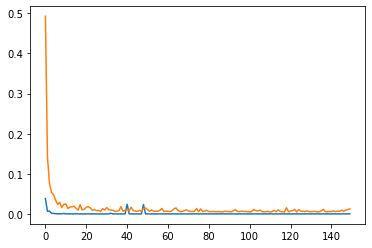

In [52]:
#save_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/2nd_gen/lstm_nested_cv/")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(cv_fold)]
loss = torch.load(loss_paths[0])
plt.plot(loss["valid"])
plt.plot(loss["train"])

In [62]:
loss["valid"]

[0.038275364572744004,
 0.006496630941639212,
 0.007118084827531204,
 0.0015915293516488552,
 0.0010822142654118374,
 0.0005476913199058875,
 0.00025775531196631403,
 0.00036438975437178423,
 0.0004206836392232327,
 0.0010816601966685947,
 0.0001348290596247545,
 9.549666597538391e-05,
 9.368790494647888e-05,
 6.316503052019715e-05,
 0.00016642117575421062,
 0.0005799276344025192,
 5.817182183423372e-05,
 7.473283968963152e-05,
 5.785907618580862e-05,
 8.123632972566654e-05,
 0.00011006089417270009,
 0.00010894037903929481,
 7.505327318957428e-05,
 8.697827858972463e-05,
 6.215691298750903e-05,
 7.177002612856417e-05,
 5.487165606301589e-05,
 5.158220059604048e-05,
 5.885413350020009e-05,
 6.41676532070677e-05,
 5.000418204487166e-05,
 6.870721597330866e-05,
 0.0016649292731442775,
 7.414867045755267e-05,
 6.301586914061043e-05,
 4.7123437407359e-05,
 4.4262710362576464e-05,
 5.3750781285382146e-05,
 6.433798866177711e-05,
 4.133874823271656e-05,
 0.02394761474027209,
 5.80038471040871

### LOO validation

In [9]:
model_title = "Single LSTM PS"

save_dir = Path(out_dir / "lstm_ps_single")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [10]:
model_title = "LSTM PS"

save_dir = Path(out_dir / "lstm_ps")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

In [11]:
model_title = "LSTM PS+ESM"

save_dir = Path(out_dir / "lstm_esm_ps")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

In [12]:
model_title = "LSTM ESM"

save_dir = Path(out_dir / "lstm_esm")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

In [13]:
model_title = "ProteinSolver (BC)"

save_dir = Path(out_dir / "proteinsolver_finetune")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [49]:
overall_LOO_results_df

,Model,AUC,MCC (threshold = 0.1)
0,LSTM ps,0.545524,-0.004330
1,LSTM PS+ESM,0.548577,0.039333
2,LSTM ESM,0.522996,0.019194
3,ProteinSolver (BC),0.515638,0.011352
4,ProteinSolver FoldX (BC),0.515638,0.011352
5,ProteinSolver FoldX (BC),0.385719,-0.091027
6,ProteinSolver FoldX (BC),0.385719,-0.091027
7,LSTM PS FoldX,0.498670,-0.012896


In [14]:
model_title = "LSTM PS FoldX"

save_dir = Path(out_dir / "lstm_ps_foldx")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

Fail for idx 13
Fail for idx 14


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


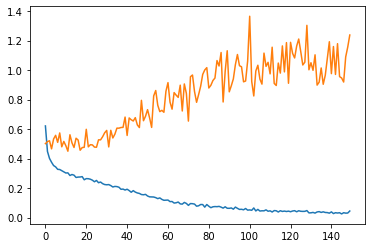

In [52]:
import matplotlib.pyplot as plt
save_dir = Path(out_dir / "lstm_esm_ps_foldx")
#pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
t = torch.load(save_dir/"loss_8.pt")
plt.plot(t["train"])
plt.plot(t["valid"])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.])

In [63]:
i = 6
print(torch.load(pred_paths[i])["y_true"])
print(torch.load(pred_paths[i])["y_pred"])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.])
tensor([4.9397e-03, 9.1846e-01, 1.0146e-04, 2.1329e-04, 6.2247e-05, 5.8632e-05,
        6.7849e-04, 1.3871e-04, 5.8798e-01, 1.3590e-04, 4.0450e-05, 2.4562e-04,
        8.0320e-05, 7.5722e-03, 5.1482e-05, 6.9943e-03, 9.0047e-04, 1.0145e-04,
        1.2694e-04, 1.2195e-04, 9.9330e-05, 1.1898e-04, 7.1750e-05, 1.3996e-04,
        4.4894e-04, 1.0442e-04, 7.9425e-03, 3.4895e-05, 8.0326e-01, 1.5276e-04,
        1.2213e-04, 1.9038e-04, 1.2265e-03, 2.8116e-03, 2.3245e-04, 1.5648e-04,
        6.9456e-03])


In [53]:
model_title = "LSTM PS+ESM FoldX"

save_dir = Path(out_dir / "lstm_esm_ps_foldx")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fail for idx 13
Fail for idx 14


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


In [16]:
model_title = "ProteinSolver FoldX (BC)"

save_dir = Path(out_dir / "proteinsolver_finetune_foldx")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

Fail for idx 13
Fail for idx 14


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


In [17]:
model_title = "LSTM PS Rosetta"

save_dir = Path(out_dir / "lstm_ps_rosetta")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

Fail for idx 13
Fail for idx 14


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


In [18]:
model_title = "LSTM PS+ESM Rosetta"

save_dir = Path(out_dir / "lstm_esm_ps_rosetta")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fail for idx 13
Fail for idx 14


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


In [19]:
model_title = "ProteinSolver Rosetta (BC)"

save_dir = Path(out_dir / "proteinsolver_finetune_rosetta")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

Fail for idx 13
Fail for idx 14


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


In [68]:
model_title = "LSTM PS CDR3+peptide"

save_dir = Path(out_dir / "lstm_ps_cdr_pep_only")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(len(unique_peptides))]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_LOO_results_df = overall_LOO_results_df.append(
    pd.Series(overall_row, index=overall_LOO_results_df.columns), ignore_index=True
)
individual_AUC_results_df = individual_AUC_results_df.append(
    pd.Series([model_title] + individual_auc, index=individual_AUC_results_df.columns), ignore_index=True
)
individual_MCC_results_df = individual_MCC_results_df.append(
    pd.Series([model_title] + individual_mcc, index=individual_MCC_results_df.columns), ignore_index=True
)

In [69]:
overall_LOO_results_df

,Model,AUC,MCC (threshold = 0.1)
0,Single LSTM PS,0.459207,0.000790
1,LSTM PS,0.545524,-0.004330
2,LSTM PS+ESM,0.548577,0.039333
3,LSTM ESM,0.522996,0.019194
4,ProteinSolver (BC),0.515638,0.011352
5,LSTM PS FoldX,0.498670,-0.012896
6,LSTM PS+ESM FoldX,0.641673,0.133461
7,ProteinSolver FoldX (BC),0.484610,0.008351
8,LSTM PS Rosetta,0.442858,-0.044289
9,LSTM PS+ESM Rosetta,0.438228,-0.021109


In [70]:
individual_AUC_results_df

,Model,NLVPMVATV,SLFNTVATL,RTLNAWVKV,KVLEYVIKV,YLLEMLWRL,IMDQVPFSV,MLDLQPETT,FLYALALLL,SLLMWITQV,LLFGYPVYV,GLCTLVAML,RMFPNAPYL,GILGFVFTL,KLQCVDLHV,KVAELVHFL
0,Single LSTM PS,0.552579,0.367347,0.613191,0.435185,0.727273,0.375000,0.565341,0.258385,0.717647,0.508267,0.603484,0.427350,0.447142,0.5,1.0
1,LSTM PS,0.562955,0.359184,0.592692,0.296296,0.333333,0.453704,0.605114,0.188820,0.576471,0.484533,0.590828,0.387464,0.559132,0.75,0.0
2,LSTM PS+ESM,0.632959,0.306122,0.566845,0.453704,0.585859,0.590278,0.607955,0.655590,0.494118,0.438667,0.619708,0.433048,0.538507,0.25,0.0
3,LSTM ESM,0.606408,0.265306,0.446970,0.388889,0.515152,0.550926,0.710227,0.422671,0.588235,0.462933,0.601947,0.478632,0.539046,0.75,0.0
4,ProteinSolver (BC),0.583217,0.526531,0.499554,0.601852,0.454545,0.555556,0.446023,0.349689,0.694118,0.529867,0.637425,0.509972,0.504736,0.25,0.5
5,LSTM PS FoldX,0.624074,0.266667,0.536341,0.564103,0.666667,0.428571,0.480159,0.569737,0.291667,0.398423,0.593248,0.308036,0.487150,None,None
6,LSTM PS+ESM FoldX,0.621553,0.242857,0.642857,0.217949,0.461538,0.477273,0.698413,0.302193,0.166667,0.470315,0.519010,0.343750,0.692714,None,None
7,ProteinSolver FoldX (BC),0.594675,0.490476,0.617794,0.423077,0.551282,0.250000,0.440476,0.503509,0.458333,0.485158,0.664119,0.629464,0.464717,None,None
8,LSTM PS Rosetta,0.621838,0.423810,0.487469,0.628205,0.615385,0.425325,0.440476,0.248684,0.541667,0.496289,0.477477,0.459821,0.443263,None,None
9,LSTM PS+ESM Rosetta,0.578564,0.261905,0.504386,0.410256,0.820513,0.470779,0.638889,0.488596,0.458333,0.524119,0.584157,0.415179,0.367202,None,None


### 5 fold CV

In [69]:
model_title = "LSTM PS"

save_dir = Path(out_dir / "lstm_ps_80_cv/")
pred_paths = [save_dir / f"pred_{i}.pt" for i in range(cv_fold)]
overall_auc, overall_fpr, overall_tpr, individual_auc, overall_mcc, individual_mcc = compute_auc_mcc(pred_paths, threshold)
overall_row = [model_title, overall_auc, overall_mcc]
overall_CV_results_df = overall_CV_results_df.append(
    pd.Series(overall_row, index=overall_CV_results_df.columns), ignore_index=True
)


In [70]:
overall_CV_results_df

,Model,AUC,MCC (threshold = 0.1)
0,LSTM PS,0.575790,0.000000
1,LSTM PS,0.867809,0.465782


In [18]:
data = torch.load(pred_paths[4])
pred = data["y_pred"]
true = data["y_true"]
roc_auc_score(true, pred)



0.5426050841389187

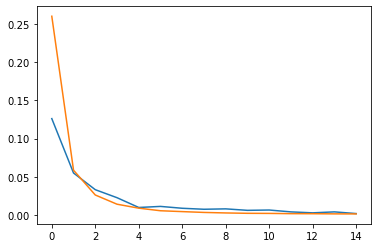

In [26]:
save_dir = Path("/home/sebastian/masters/data/state_files/tcr_binding/2nd_gen/lstm_nested_cv/")
loss_paths = [save_dir / f"loss_{i}.pt" for i in range(cv_fold)]
loss = torch.load(loss_paths[0])
plt.plot(loss["valid"])
plt.plot(loss["train"])

In [27]:
loss

{'train': [0.2599909547465287,
  0.0587380253207669,
  0.02636778531293613,
  0.014318950354137603,
  0.009148004564599879,
  0.005773522714947581,
  0.004648978285081731,
  0.0035717326372119427,
  0.002899539516304275,
  0.0024271780132360567,
  0.0023026488964865612,
  0.0019673858301115722,
  0.0018986245129995309,
  0.0016928086376591476,
  0.0016307452094456404],
 'valid': [0.1261919606899313,
  0.05510136378956411,
  0.03330035214928691,
  0.022833650346786038,
  0.010042277259772699,
  0.011441605346715055,
  0.009012943187068837,
  0.007716186174351891,
  0.008234350842137835,
  0.006305635037885319,
  0.006714706292733157,
  0.004279460249973436,
  0.003039304290010192,
  0.004289030305182107,
  0.0020906578920492427]}

In [11]:
pred

tensor([0.0019, 0.0019, 0.0025,  ..., 0.0022, 0.0015, 0.0020])

In [26]:
true

tensor([0., 0., 0.,  ..., 1., 0., 1.])